# TODOs
- [X] Metadaten.json zu Python Variablen, in Python Dictionary einspeisen und auslesen (Parkplätze, WiFi) -> Frank
- [X] Map (Slider, Heat Map, Animationen) Visualisierungen -> Frank
- [X] virtual env vorbereiten -> Rich
- [X] projektserver? -> Rich
- [X] Erste Statistiken (Bar Charts, Graphs usw.) Visualisierungen -> Rich
- [ ] Chart Ideen -> Anja
- [ ] Unsere Daten in PowerBI einspeisen, (welche Daten bräuchten wir z.B. für Graph Bubble oder allgemeine Sachen) oder was kostenloses (z.B. CliqSense) -> Anja

# Unsere Quellen zum Visualisierungserfolg:
### Wie Wähle ich die richtige Visualisierung?

https://eazybi.com/blog/data_visualization_and_chart_types/

### Wo finde ich sie in Python?

https://python-graph-gallery.com

# Domänenwissen

* Öffnungszeiten (Theater, Uni)
* Peak Times, Tag
* Ferienzeiten
* Special Events (Demos, Strassensperren)
* Parkplätze kostenlos/bezahlt?
* Sonntag Flohmarkt

# Ideen
* Vergleich mit Wetterdaten
* Verlgeich mit Öffis -> Empfehlungen aussprechen -> z.B. mehr Busse sollen fahren, aber eine U-Bahn kann ausfallen
* Anhand von hauptsächlich Fußgänger könnte man behaupten, wann Vorlesungen auf der TU sind

# Korrelation
* Wie viele fahren rein um bestimmte Uhrzeit rein -> Belegung Parkplätze
* WiFi Nutzung in Zusammenhang mit parkenden Autos?

# Prädiktionen (ML)
* Traffic-/Personenaufkommen zu bestimmten Tageszeiten

# Distribution
* Normalverteilung

# Intervall
* Tageszeiten
* Wochen

# Fragen flow.lab
* Wie wurden Pedestrian Daten aufgenommen?
* Was sind die Daten bei WiFi?
* Gibt es schon Ergebnisse aus Wettbewerb?
* Gibt es neue Daten?
* Erklärung zu Datenset?

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import folium.plugins as plugins
from IPython.display import HTML
import sklearn as sk
import numpy as np
import json

### Erklärungen/Links zu wichtigen Libraries
- Markdown schreiben hier in Jupyter: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Daten einlesen
> Erns-Reuter-Platz Datensatz aus http://flow.dai-labor.de

In [152]:
wifi = pd.read_csv('data/wifi.csv')
parking = pd.read_csv('data/parking.csv', delimiter=' ')
# TODO: hier restlichen Datensätze einlesen

### Sinn aus den Daten machen 

In [153]:
# TODO: alle Typen aus der metadata.json in Python Variablen, z.B.:
campus_eb = [52.512388, 13.32360925]
campus_tel = [52.51298775, 13.32029525]
ernst_reuter_platz_center = [52.512611, 13.321856]

# TODO: json daten auslesen
metadata = json.loads(open('data/metadata.json').read())

wifi_latlon = metadata['wifi']['latlon']
pedestrian_latlon = metadata['pedestrian']['latlon']
traffic_latlon = metadata['traffic']['latlon']
parking_latlon = metadata['parking']['latlon']

### Wichtige Libraries
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Alle WiFi Standorte auf Karte visualisieren

In [154]:
## TODO: take center of ernst-reuter platz as location=POINT
map = folium.Map(location=ernst_reuter_platz_center, zoom_start=17)


for key in wifi_latlon:
    folium.Circle(
        radius=50,
        location=wifi_latlon[key],
        popup=key,
        color='#3186cc',
        fill=True
    ).add_to(map)
    
for key in pedestrian_latlon:
    folium.Marker(
        location=pedestrian_latlon[key],
        popup=key,
        icon=folium.Icon(icon='info-sign')
    ).add_to(map)
    
for key in traffic_latlon:
    folium.Marker(
        location=traffic_latlon[key],
        popup=key,
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_to(map)

for key in parking_latlon:
    folium.Circle(
        radius=2,
        location=parking_latlon[key],
        popup=key,
        color='red',
        fill=True
    ).add_to(map)

map

### Zum Vergleich Originalstandorte:
(TODO: Karte rotieren?)

![Sensor_Locations](images/Sensor_Locations.jpg)

### Parking Data

In [155]:
mean_parking = {}

startTime = float(parking[['Timestamp']].iloc[0])
endTime = float(parking[['Timestamp']].iloc[-1])
timeSpan = endTime - startTime

for key in parking_latlon:
    temp = parking[parking['ParkingSpotID'] == key][['Timestamp','Occupied']]
    occupied = temp.iloc[0]['Occupied'] == 1
    lastTime = startTime
    mean_parking[key] = 0
    for index, row in temp.iterrows():
        if occupied != (row['Occupied'] == 1):
            if occupied:
                mean_parking[key] += row['Timestamp'] - lastTime
            else:
                lastTime = row['Timestamp']
            occupied = row['Occupied'] == 1
    if occupied:
                mean_parking[key] += endTime - lastTime
    mean_parking[key] /= timeSpan
    print(key, ":", mean_parking[key])
                
        
    
## mean_parking[key] = parking[parking['ParkingSpotID'] == key][['Occupied']].mean()    
## This is the wrong aproach! data points are only created when the Occupied property changes, so the Mean has to be around 50%
## the correct way is to calculate the mean-time the Parking Spot was occupied

##print(mean_parking)


LZQ2AMNPAAAAU7QDBHVMEVVZ : 0.4745755398860814
LZQ2AMXWAAAAU7QDBHFOWJM5 : 0.5073588844292795
LZQ2AN4NAAAAU7QDBHQGNAFN : 0.44496773662609473
LZQ2ANAVAAAAU7QDBFBNCMYI : 0.40650217531453403
LZQ2ANJGAAAAU7QDBFCQE74V : 0.3927269087100178
LZQ2ANSFAAAAU7QDBHGHYITI : 0.5066861406338022
LZQ2AO5NAAAAU7QDBHHNGG7J : 0.3959405832415216
LZQ2AOEPAAAAU7QDBHZM5ZYB : 0.30792665329694974
LZQ2AOMUAAAAU7QDBHBEY6HX : 0.4171694467749902
LZQ2AOVHAAAAU7QDBF2FWKNL : 0.35652623531929434
LZQ2AP7HAAAAU7QDBENVJF67 : 0.2668880001103557
LZQ2APGFAAAAU7QDBHUW4O3U : 0.3705665578094636
LZQ2APPBAAAAU7QDBG66NGI4 : 0.41937895407675896
LZQ2APWZAAAAU7QDBE74KH4Y : 0.37209460567403124
LZQ2AQHIAAAAU7QDBFQAPZRO : 0.5293633821403173
LZQ2AQPOAAAAU7QDBEOQ7GRC : 0.43051202648294506
LZQ2AQYZAAAAU7QDBHZLKV4Z : 0.3735082130365179
LZQ2ARBLAAAAU7QDBHHHZXBS : 0.43668823875065543
LZQ2ARKXAAAAU7QDBH3D725J : 0.41271667139640544
LZQ2ARSCAAAAU7QDBFQXMEGM : 0.4293735834663292
LZQ2ARZTAAAAU7QDBEBS7S4V : 0.42231784320333643
LZQ2ASBXAAAAU7QDBFRTOMVS

In [156]:
parkplatz_center = [52.513025, 13.319505]
parking_map = folium.Map(location=parkplatz_center, zoom_start=18)

for key in parking_latlon:
    visual = (mean_parking[key] - 0.25) * 2
    folium.Circle(
        radius=1,
        location=parking_latlon[key],
        popup=key,
        color='#%02x%02x%02x' % (int(255 * visual), 0, int(255 * (1 - visual))),
        fill=True
    ).add_to(parking_map)
    
## rot = häufig belegt, blau = weniger häufig belegt

parking_map

## Basic Statistics

### Pedestrians

In [157]:
df_pedestrians_original = pd.read_csv('data/pedestrian_counts_tel_a.csv', sep=" ")
print('Total number of entries: \n\n' + str(df_pedestrians_original.count()))
print('\n\nExample Output: ')
df_pedestrians_original.head()

Total number of entries: 

StationIdentifier    402616
Timestamp            402616
Direction            402616
Count                402616
dtype: int64


Example Output: 


,StationIdentifier,Timestamp,Direction,Count
0,CounterVorplatzGeb-AF2-PeopleCounter,1515525300416,IN,0
1,CounterVorplatzGeb-AF2-PeopleCounter,1515525300418,OUT,0
2,CounterHaupteingang-TEL4-PeopleCounter,1515525300417,IN,0
3,CounterHaupteingang-TEL4-PeopleCounter,1515525300415,OUT,0
4,CounterVorplatzGeb-AF2-PeopleCounter,1515525360372,IN,0


### Clean

In [163]:
# clone for backup
df_pedestrians = df_pedestrians_original
# rename
df_pedestrians = df_pedestrians.replace({'CounterVorplatzGeb-AF2-PeopleCounter':'af_counter', 'CounterHaupteingang-TEL4-PeopleCounter':'telekom_counter'})
# drop zero counts
df_pedestrians = df_pedestrians[df_pedestrians.Count != 0]
print('Total number of entries: \n\n' + str(df_pedestrians.count()))

Total number of entries: 

StationIdentifier    69047
Timestamp            69047
Direction            69047
Count                69047
dtype: int64


### Verify Dataset Integrity

In [185]:
df_pedestrians_IN = df_pedestrians[df_pedestrians['Direction'] == 'IN'] 
df_pedestrians_OUT = df_pedestrians[df_pedestrians['Direction'] == 'OUT']

In [192]:
df_pedestrians_IN_af = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'af_counter']
df_pedestrians_OUT_af = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'af_counter']
df_pedestrians_IN_tel = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'telekom_counter']
df_pedestrians_OUT_tel = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'telekom_counter']

count_total_IN_records = df_pedestrians_IN['Count'].count()
count_total_OUT_records = df_pedestrians_OUT['Count'].count()
count_walked_IN_af = df_pedestrians_IN_af.Count.sum()
count_walked_OUT_af = df_pedestrians_OUT_af.Count.sum()
count_walked_IN_tel = df_pedestrians_IN_tel.Count.sum()
count_walked_OUT_tel = df_pedestrians_OUT_tel.Count.sum()

print('The buildings must be spawning pedestrians from the cellar 😱🧙')
print('Or there might be different Entries to the building.')

The buildings must be spawning pedestrians from the cellar 😱🧙
Or there might be different Entries to the building.


### Visualize

26957


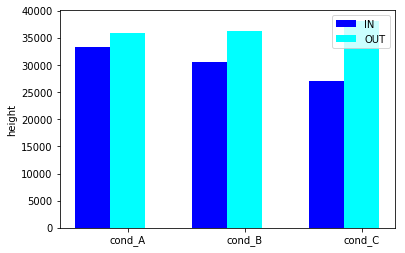

In [198]:
# as bar chart
bar_width = 0.3
print(count_walked_IN_tel)
bars1 = [count_total_IN_records, count_walked_IN_af, count_walked_IN_tel]
bars2 = [count_total_OUT_records, count_walked_OUT_af, count_walked_OUT_tel]
# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + bar_width for x in r1]
# create bars1
plt.bar(r1, bars1, width=bar_width, color='blue', capsize=7, label='IN')
plt.bar(r2, bars2, width=bar_width, color='cyan', capsize=7, label='OUT')

# general layout
plt.xticks([r + bar_width for r in range(len(bars1))], ['cond_A', 'cond_B', 'cond_C'])
plt.ylabel('height')
plt.legend()

# Show graphic
plt.show()